# Face Detection for crowd analysis


This notebook evaluates the effectivness of MASK RCNN for the task of face detection given obscured images. We hypothesize that the nature of the algorithm for semantic segmentation is inherintly better than the current state of the art detection algorithms for obscured images.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

/home/arthur/anaconda2/envs/mask_rcnn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Configurations

In [2]:
class FacesConfig(Config):
    """Configuration for training on the lfw dataset
    Derives from the base Config class and overrides values specific
    to the lfw dataset.
    """
    # Give the configuration a recognizable name
    NAME = "faces"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + face and hair

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = FacesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           faces
NUM_CLASSES                    3
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         200

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Build lfw image paths

As the annonated set of images is only a subset of the lfw database, we need to extract a list of images that are annotated and return them as an array to pass to FacesDataset

In [4]:
def _build_paths(image_dir, label_dir, image_subdir, label_file):
    image_file = label_file[:-3] + 'jpg'
    image_path = os.path.join(image_dir, image_subdir, image_file)
    label_path = os.path.join(label_dir, label_file)
    return [image_path, label_path]

def get_image_paths(image_dir, label_dir):
    label_files = []
    train_files = []

    for filename in os.listdir(label_dir):
        if filename.endswith(".ppm"):
            label_files.append(filename)

    for label_file in label_files:
        image_file = label_file[:-9]
        train_files.append(_build_paths(image_dir, label_dir, image_file, label_file))

    return train_files

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the faces dataset, `load_faces()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
from random import randint

class FacesDataset(utils.Dataset):
    """Generates the lfw dataset """
    
    def __init__(self, images, obscured=False):
        self.images = images
        self.obscured = obscured
        super().__init__()

    def load_faces(self, start, end, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("faces", 1, "face")
        #self.add_class("faces", 2, "hair")
        
        center = 128
        _width = 80

        for idx, img in enumerate(self.images):
            if idx < start:
                continue
            if idx > end:
                continue
            bg_color = np.array([0, 0, 255])
            x = randint(center - _width, center + _width)
            y = randint(center - _width, center + _width)
            self.add_image("faces", image_id=idx, path=img[0],
                           width=width, height=height,
                           bg_color=bg_color, obscured=self.obscured, x=x, y=y)

    def load_image(self, image_id):
        img = cv2.imread(self.images[image_id][0])
        height, width = img.shape[:2]
        img = cv2.resize(img,(width+6, height+6), interpolation = cv2.INTER_CUBIC)
        info = self.image_info[image_id]
        
        if self.obscured:
            # Add a random shape in the image to obstruct the face
            cv2.circle(img, (info['x'],info['y']), self.obscured, (0,0,0), -1)
        
        return img
    
    def image_reference(self, image_id):
        """Return the face data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "faces":
            return info
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for faces of the given image ID.
        """
        mask = cv2.imread(self.images[image_id][1])
        height, width = mask.shape[:2]
        mask = cv2.resize(mask,(width+6, height+6), interpolation = cv2.INTER_CUBIC)
        class_ids = np.array([1])

        info = self.image_info[image_id]
        if self.obscured:
            # Add a random shape in the image to obstruct the face
            cv2.circle(mask, (info['x'],info['y']), self.obscured, (0,0,0), -1)

        binary_mask = np.zeros([info['height'], info['width'], 1], dtype=np.uint8)
        
        for r in range(mask.shape[0]):
            for c in range(mask.shape[1]):
                g = mask[r][c][1]
                if g == 255:
                    binary_mask[r][c] = 1
        
        return binary_mask, class_ids.astype(np.int32)    

In [6]:
# Change these to the base folder for the lfw dataset
LFW_BASE = '/home/arthur/Downloads/lfw_funneled'
LFW_PARTS_BASE = '/home/arthur/Downloads/parts_lfw_funneled_gt_images/'

images = get_image_paths(LFW_BASE, LFW_PARTS_BASE)
num_images = len(images)
train_split = int(math.floor(num_images * 0.8))

# Training dataset
dataset_train = FacesDataset(images)
dataset_train.load_faces(0, train_split, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation datasets
val_datasets = []
radius = 0
increment = 10

for i in range(10):
    ds = FacesDataset(images, radius)
    ds.load_faces(train_split + 1, num_images - 1, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
    ds.prepare()
    val_datasets.append(ds)
    radius += increment

(256, 256, 1)


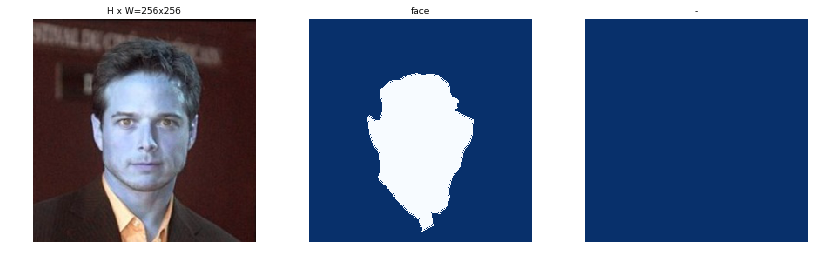

(256, 256, 1)


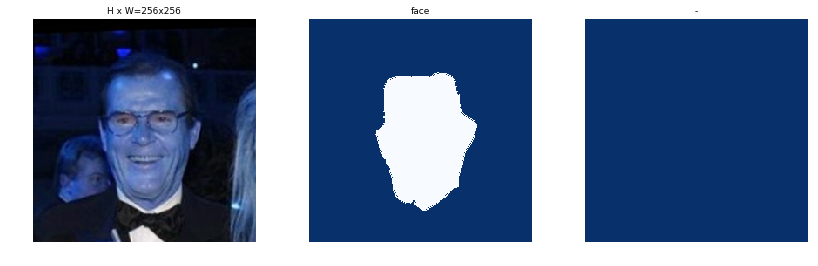

(256, 256, 1)


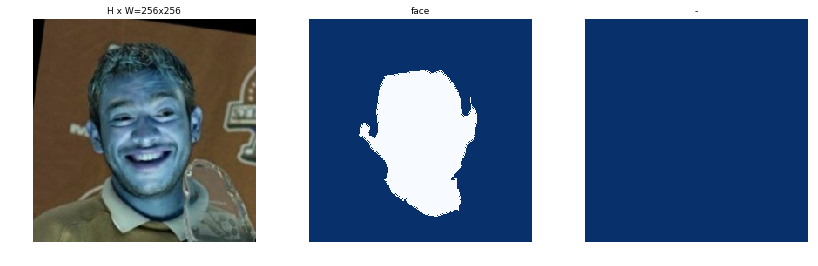

(256, 256, 1)


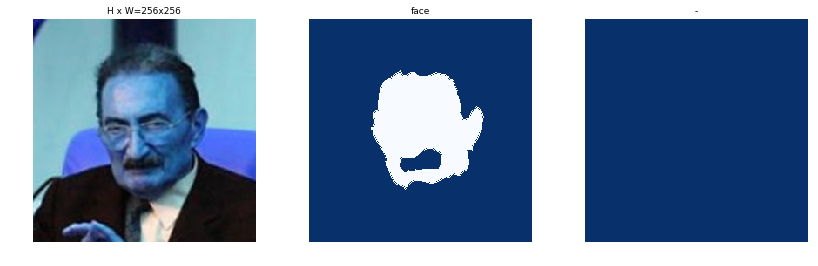

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 2)

## Detection

In [8]:
class InferenceConfig(FacesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/arthur/code/Mask_RCNN/logs/faces20180111T1433/mask_rcnn_faces_0002.h5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  421.00000
gt_class_id              shape: (1, 4)                min:   55.00000  max:  256.00000
gt_bbox                  shape: (1, 4)                min:   55.00000  max:  256.00000
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000


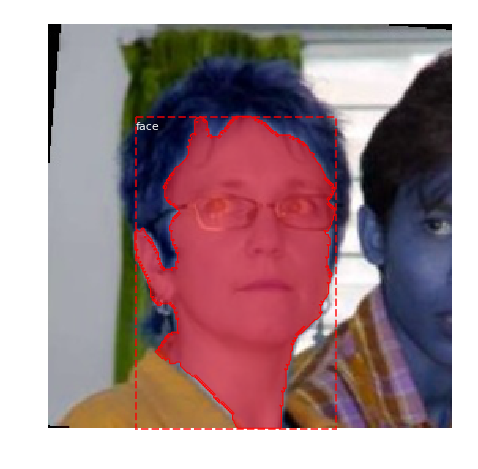

In [9]:
dataset_val = val_datasets[0]
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [10]:
import colorsys
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color):
    image[:, :, 0] = np.where(mask == 1, 1, 0)
    return image

def display_instances(image, masks, gt_mask):
    
    # masked_image = image.astype(np.uint32).copy()
    masked_image = np.zeros((256, 256, 1), dtype=np.uint32)
    i = 0
    alpha = 0.5
    colors = random_colors(1)
    color = colors[i]
    # Mask
    mask = masks[:, :, i]
    masked_image = apply_mask(masked_image, mask, color)
    
    gt_mask = gt_mask.ravel()
    image = masked_image.ravel()
    return average_precision_score(gt_mask, image)

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 11)               min:    0.00000  max:  256.00000
3.4589405059814453


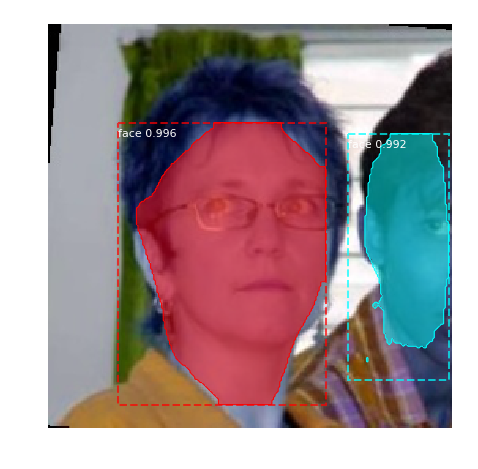

In [11]:
import time
start = time.time()
# img = cv2.imread('/home/arthur/latest.png')
# print(img.shape)
# img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
# results = model.detect([img], verbose=1)
results = model.detect([original_image], verbose=1)
end = time.time()
print(end - start)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

#display_instances(original_image, r['masks'])

## Evaluation

In [12]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
total = 0
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    total += r["scores"][0]
    
print('Avg score: ', total / 10)
print("mAP: ", np.mean(APs))

Avg score:  0.99250048399
mAP:  1.0


Compute the AOC For detection accuracy relative to IoU amounts

In [13]:
import cv2
from sklearn.metrics import average_precision_score

face_cascade = cv2.CascadeClassifier('assets/haarcascade_frontalface_default.xml')

ccAPs = []

def compute_cc_ap(dataset, image_id, threshold):
    mask, class_ids = dataset.load_mask(image_id)
    # print('id', image_id)
    img = dataset.load_image(image_id)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    detected_mask = np.zeros(mask.shape, dtype=int)
    #print('zeros', detected_mask)
    if len(faces) > 0:
        x, y, w, h = faces[0]
        detected_mask[y:(y+h), x:(x+w)] = 1
        # print('detected', detected_mask.shape)
    
    predicted = detected_mask.ravel()
    ground_truth = mask.ravel()
    
    ap = average_precision_score(ground_truth, predicted)
    return 1 if ap > threshold else 0
    

DLiB nn

In [14]:
import dlib
from skimage import io

cnn_face_detector = dlib.cnn_face_detection_model_v1('assets/mmod_human_face_detector.dat')

dlibAPs = []

def compute_dlib_ap(dataset, image_id, threshold):
    info = dataset.image_reference(image_id)
    path = info['path']
    # img = io.imread(path)
    img = dataset.load_image(image_id)
    # img = dlib.load_rgb_image(path)
    dets = cnn_face_detector(img, 1)
    try:
        d = dets[0]
    except IndexError:
        return 0
    
    mask, class_ids = dataset.load_mask(image_id)
    
    detected_mask = np.zeros(mask.shape, dtype=int)

    y = d.rect.bottom()
    y2 = d.rect.top()
    x = d.rect.left()
    x2 = d.rect.right()
    detected_mask[y2:y, x:x2] = 1
    
    predicted = detected_mask.ravel()
    ground_truth = mask.ravel()
    
    ap = average_precision_score(ground_truth, predicted)
    # print('dlib ap', ap)
    return 1 if ap > threshold else 0

Dlib face detector

In [15]:
detector = dlib.get_frontal_face_detector()

hogAPs = []

def compute_hog_ap(dataset, image_id, threshold):
    info = dataset.image_reference(image_id)
    path = info['path']
    # img = io.imread(path)
    img = dataset.load_image(image_id)
    # img = dlib.load_rgb_image(path)
    dets = detector(img, 1)
    try:
        d = dets[0]
    except IndexError:
        return 0
    
    mask, class_ids = dataset.load_mask(image_id)
    
    detected_mask = np.zeros(mask.shape, dtype=int)
    
    y = d.bottom()
    y2 = d.top()
    x = d.left()
    x2 = d.right()
    detected_mask[y2:y, x:x2] = 1
    
    predicted = detected_mask.ravel()
    ground_truth = mask.ravel()
    
    ap = average_precision_score(ground_truth, predicted)

    return 1 if ap > threshold else 0

In [ ]:
from datetime import datetime
# np.seterr(divide='ignore', invalid='ignore')

threshold = 0.5

all_APs = []
all_ccAPs = []
all_dlibAPs = []
all_hogAPs = []

for dataset in val_datasets:
    APs = []
    ccAPs = []
    for image_id in dataset.image_ids:

        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,image_id, use_mini_mask=False)

        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)

        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        
        # print('sdfsdf', original_image.shape, r['masks'].shape, gt_mask.shape)
        # _ap = display_instances(original_image, r['masks'], gt_mask)

        # print(gt_bbox, gt_class_id, r["rois"], r["class_ids"], r["scores"], threshold)
        
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, r["rois"], r["class_ids"], r["scores"])

        # Compute AP for cc detector
        ccAP = compute_cc_ap(dataset, image_id, 0.5)
        
        dlibAP = compute_dlib_ap(dataset, image_id, 0.5)
        
        hogAP = compute_hog_ap(dataset, image_id, 0.5)

        # Append to average counter for IoU threshold
        APs.append(AP)
        ccAPs.append(ccAP)
        dlibAPs.append(dlibAP)
        hogAPs.append(hogAP)

    print('Mean Average Precision for cascade classifier : ', np.mean(ccAPs))
    print('Mean Average Precision for semantic segmentation : ', np.mean(APs))
    print('Mean Average Precision for dlib : ', np.mean(dlibAPs))
    print('Mean Average Precision for hog : ', np.mean(hogAPs))
    all_APs.append(np.mean(APs))
    all_ccAPs.append(np.mean(ccAPs))
    all_dlibAPs.append(np.mean(dlibAPs))
    all_hogAPs.append(np.mean(hogAPs))

# all_APs = [3.2, 4.1, 4.2, 4.32, 4.7, 5.11, 6, 6, 6, 6]
# all_ccAPs = [3.6, 4.7, 4.9, 4.32, 5.7, 6.11, 6, 6, 6, 6]
# all_dlibAPs = [3.2, 4.1, 4.2, 4.32, 4.7, 7.11, 6, 6, 6, 6]
# all_hogAPs = [2.2, 3.1, 4.12, 4.32, 5.7, 6.11, 6, 6, 6, 6]
    
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import trapz

mask = plt.plot(range(0, 100, 10), all_APs, label='Mask RCNN [AUC=%.2f]' % trapz(all_APs, dx=10))
cc = plt.plot(range(0, 100, 10), all_ccAPs, label='Cascade Classifier [AUC=%.2f]' % trapz(all_ccAPs, dx=10))
mmod = plt.plot(range(0, 100, 10), all_dlibAPs, label='MMOD [AUC=%.2f]' % trapz(all_dlibAPs, dx=10))
hog = plt.plot(range(0, 100, 10), all_hogAPs, label='HOG Linear [AUC=%.2f]' % trapz(all_hogAPs, dx=10))

plt.legend(loc='lower left', fontsize="small")

plt.ylabel('Average Precision @ 0.5')
plt.xlabel('Amount of Occlusion (px)')
plt.axis([0, 90, 0, 1])
plt.grid(True)
plt.savefig(os.path.join(MODEL_DIR, "results_%s.png" % datetime.now()))
plt.show()

import numpy as np

# The y values.  A numpy array is used here,
# but a python list could also be used.
# y = np.array(list(map(lambda iou: np.mean(iou[1]), IoUs)))
# ccY = np.array(list(map(lambda iou: np.mean(iou[1]), ccIoUs)))

# maxIoU = max(map(lambda iou: iou[0], filter(lambda iou: np.mean(iou[1]) > 0, IoUs)))

# ccMaxIoU = max(map(lambda iou: iou[0], filter(lambda iou: np.mean(iou[1]) > 0, ccIoUs)))

# print('Max IoU threshold = ', maxIoU)
# print('Max IoU threshold for cc face detector = ', ccMaxIoU)

# Compute the area using the composite trapezoidal rule.
area = trapz(all_APs, dx=10)
print("AOC using composite trapezoidal rule =", area)

# Compute the area using the composite trapezoidal rule.
area = trapz(all_ccAPs, dx=10)
print("AOC using composite trapezoidal rule for cc face detector =", area)

area = trapz(all_dlibAPs, dx=10)
print("AOC using composite trapezoidal rule for dlib face detector =", area)

area = trapz(all_hogAPs, dx=10)
print("AOC using composite trapezoidal rule for hog face detector =", area)

Mean Average Precision for cascade classifier :  0.864957264957
Mean Average Precision for semantic segmentation :  0.975213675214
Mean Average Precision for dlib :  0.921367521368
Mean Average Precision for hog :  0.936752136752
